# Recommender Systems

## 1 导入数据 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy import optimize as opt

In [4]:
mat = loadmat('./data/ex8_movies.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [6]:
Y = mat['Y']
R = mat['R']
Y.shape, R.shape
# Y is 1682x943 containing ratings (1-5) of 1682 movies on 943 users
# a rating of 0 means the movie wasn't rated
# R is 1682x943 containing R(i,j) = 1 if user j gave a rating to movie i

((1682, 943), (1682, 943))

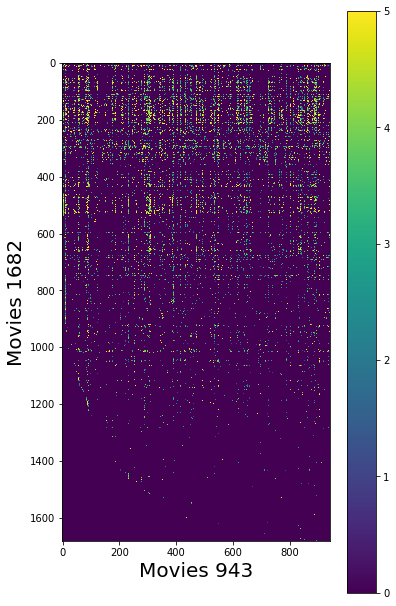

In [9]:
fig = plt.figure(figsize=(6, 6 * (num_movies / num_users)))
dummy = plt.imshow(Y)
dummy = plt.colorbar()
dummy = plt.ylabel(f'Movies {num_movies}', fontsize=20)
dummy = plt.xlabel(f'Movies {num_users}', fontsize=20)

In [10]:
param_mat = loadmat('./data/ex8_movieParams.mat')
param_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [13]:
X = param_mat['X']
Theta = param_mat['Theta']
num_users = param_mat['num_users'][0, 0]
num_movies = param_mat['num_movies'][0, 0]
num_features = param_mat['num_features'][0, 0]
X.shape, Theta.shape, num_users, num_movies, num_features

((1682, 10), (943, 10), 943, 1682, 10)

## 2 Collaborative filtering learning algorithm 协同过滤算法 

In [14]:
def serialize(X, Theta):
    return np.concatenate((X.ravel(), Theta.ravel()))
def deserialize(params, num_movies, num_users, num_features):
    return params[:num_movies*num_features].reshape((num_movies, num_features)), \
        params[num_movies*num_features:].reshape((num_users, num_features))

In [15]:
a, b = deserialize(serialize(X, Theta), num_movies, num_users, num_features)
a == X, b == Theta

(array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]))

### cost:
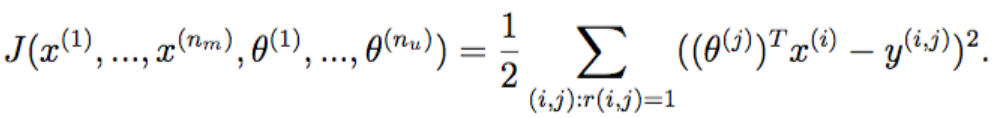

In [34]:
def cost(params, Y, R, num_features, lam=1.):
    num_movies, num_users = Y.shape
    #print(num_movies, num_users, num_features)
    X, Theta = deserialize(params, num_movies, num_users, num_features)
    
    inner = (X @ Theta.T - Y) * R
    J = np.square(inner).sum() / 2
    reg = (lam / 2) * np.square(params).sum()
    
    return J + reg

### gradient:
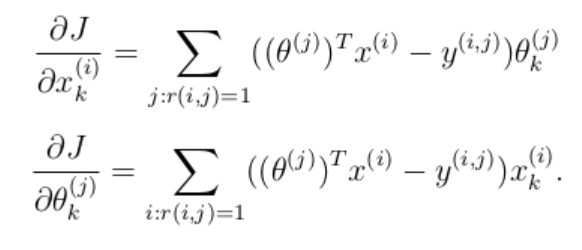

In [41]:
def grad(params, Y, R, num_features, lam=1.):
    num_movies, num_users = Y.shape
    X, Theta = deserialize(params, num_movies, num_users, num_features)
    
    inner = (X @ Theta.T - Y) * R
    
    X_grad = inner @ Theta #(1682, 10)
    Theta_grad = inner.T @ X #(943, 10)
    
    return serialize(X_grad, Theta_grad) + (lam * params)

In [42]:
# use subset of data to calculate the cost as in pdf...
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]
param_sub = serialize(X_sub, theta_sub)
cost(param_sub, Y_sub, R_sub, features, 0.)

22.224603725685675

In [40]:
R.shape

(1682, 943)

In [37]:
params = serialize(X, Theta)  # total real params

cost(params, Y, R, 10, 0.)  # this is real total cost

27918.64012454421

In [43]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(grad(params, Y, R, 10),
                                      n_movie, n_user, 10)
X_grad.shape, theta_grad.shape

((1682, 10), (943, 10))

## 3 导入电影信息 

In [52]:
movies_list = []

with open('./data/movie_ids.txt', encoding='latin-1') as f:
    for line in f:
        tokens = line.strip().split(' ')
        #print(tokens)
        movies_list.append(' '.join(tokens[1:]))

movies_list = np.array(movies_list)
movies_list.shape

(1682,)

In [53]:
movies_list[0]

'Toy Story (1995)'

## 4 Reproduce my ratings

In [54]:
ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

In [55]:
Y = np.insert(Y, 0, ratings, axis=1)  # now I become user 0
Y.shape

(1682, 944)

In [56]:
R = np.insert(R, 0, ratings != 0, axis=1)
R.shape

(1682, 944)

In [57]:
n_features = 50
n_movie, n_user = Y.shape
l = 10

In [58]:
X = np.random.standard_normal((n_movie, n_features))
theta = np.random.standard_normal((n_user, n_features))

X.shape, theta.shape

((1682, 50), (944, 50))

## 5 均值归一化 

In [59]:
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

## 6 Training 

In [60]:
%%time
res = opt.minimize(fun=cost,
                   x0=serialize(X, theta),
                   args=(Y_norm, R, n_features, l),
                   method='TNC',
                   jac=grad)

CPU times: user 5min 31s, sys: 7.08 s, total: 5min 38s
Wall time: 1min 24s


In [61]:
res

     fun: 64721.4978150673
     jac: array([-1.01769647e-07, -3.16521721e-06, -2.53683722e-06, ...,
       -9.16541412e-08, -3.03615589e-07,  1.07437255e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 2372
     nit: 77
  status: 1
 success: True
       x: array([ 0.31915944,  1.14710235,  0.40118823, ..., -0.58344623,
        0.39481255,  0.57281815])

In [62]:
X_trained, theta_trained = deserialize(res.x, n_movie, n_user, n_features)
X_trained.shape, theta_trained.shape

((1682, 50), (944, 50))

In [63]:
prediction = X_trained @ theta_trained.T

In [64]:
my_preds = prediction[:, 0] + Y.mean()

In [65]:
idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape

(1682,)

In [67]:
# top ten idx
my_preds[idx[:10]]

array([4.12535097, 4.04413443, 3.99324285, 3.91902771, 3.81690517,
       3.81556225, 3.76602627, 3.76322453, 3.75904949, 3.75078056])

In [70]:
for m in movies_list[idx[:10]]:
    print(m)

Titanic (1997)
Star Wars (1977)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Raiders of the Lost Ark (1981)
Braveheart (1995)
Return of the Jedi (1983)
Usual Suspects, The (1995)
Godfather, The (1972)
Schindler's List (1993)
